In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

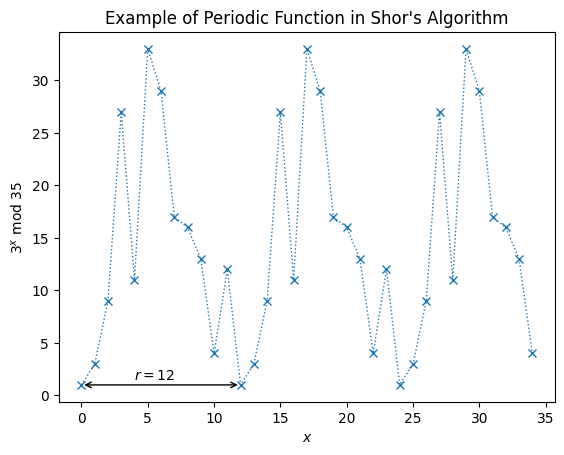

In [3]:
N = 35
a = 3

# Calculate the plotting data
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod ${N}$',
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) + 1
    plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f'$r={r}$', xy=(r/3,1.5))
except ValueError:
    print('Could not find period, check a < N and have no common factors.')

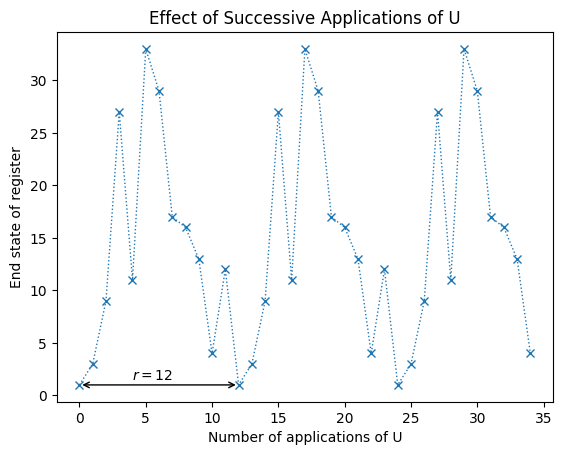

In [4]:
ax.set(xlabel='Number of applications of U',
       ylabel='End state of register',
       title="Effect of Successive Applications of U")
fig

In [5]:
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

In [6]:
# Specify variables
N_COUNT = 8  # number of counting qubits
a = 7

In [7]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

/Users/thiru/anaconda3/envs/qiskit_1.0/lib/python3.12/site-packages/qiskit/visualization/circuit/matplotlib.py:269: UserWarning: Style JSON file 'idx-dark.json' not found in any of these locations: /Users/thiru/anaconda3/envs/qiskit_1.0/lib/python3.12/site-packages/qiskit/visualization/circuit/styles/idx-dark.json, idx-dark.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


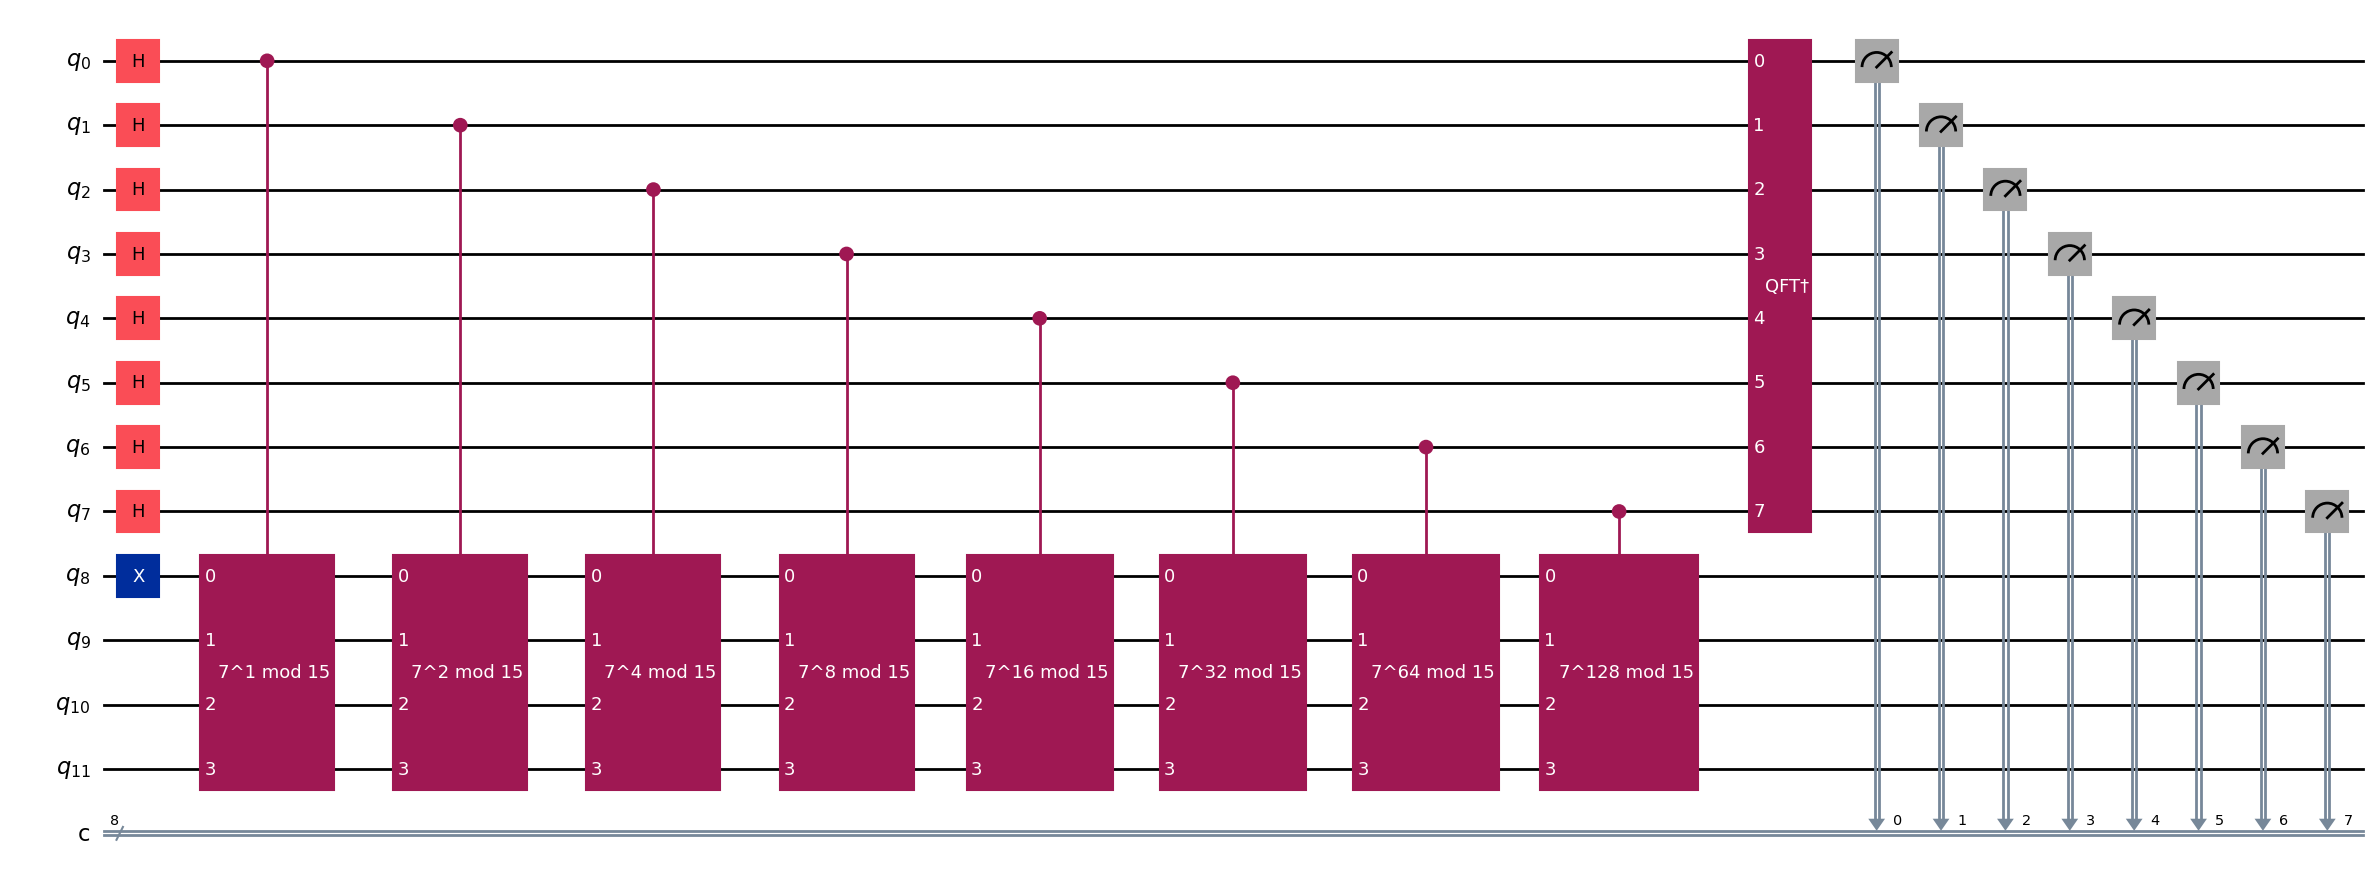

In [8]:
# Create QuantumCircuit with N_COUNT counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(N_COUNT + 4, N_COUNT)

# Initialize counting qubits
# in state |+>
for q in range(N_COUNT):
    qc.h(q)

# And auxiliary register in state |1>
qc.x(N_COUNT)

# Do controlled-U operations
for q in range(N_COUNT):
    qc.append(c_amod15(a, 2**q),
             [q] + [i+N_COUNT for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(N_COUNT), range(N_COUNT))

# Measure circuit
qc.measure(range(N_COUNT), range(N_COUNT))
qc.draw(fold=-1)  # -1 means 'do not fold'

In [10]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.providers.fake_provider import GenericBackendV2

num_qubits = N_COUNT + 4
backend = GenericBackendV2(num_qubits=num_qubits)
pass_manager = generate_preset_pass_manager(3, backend)

In [13]:
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.primitives import StatevectorSampler, PrimitiveJob
from qiskit.circuit.library import TwoLocal
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_aer import AerSimulator


In [15]:
qc.measure_all()

In [16]:
sampler = StatevectorSampler()
pub = (qc)
job_sampler = sampler.run([pub], shots=256)


### Don't change any code past this line ###

result_sampler = job_sampler.result()
counts_sampler = result_sampler[0].data.meas.get_counts()

print(counts_sampler)

{'110101000000': 16, '010010000000': 9, '000100000000': 19, '000111000000': 18, '000110000000': 28, '010011000000': 11, '110100000000': 17, '010001000000': 18, '011100000000': 17, '011110000000': 12, '010000000000': 22, '011101000000': 17, '110110000000': 11, '110111000000': 10, '000101000000': 17, '011111000000': 14}


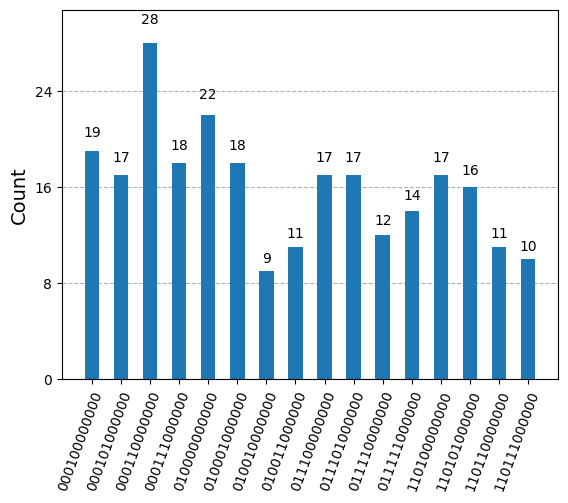

In [17]:
plot_histogram(counts_sampler)

In [19]:
rows, measured_phases = [], []
for output in counts_sampler:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**N_COUNT)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**N_COUNT} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

                  Register Output             Phase
0   110101000000(bin) = 3392(dec)  3392/256 = 13.25
1   010010000000(bin) = 1152(dec)   1152/256 = 4.50
2    000100000000(bin) = 256(dec)    256/256 = 1.00
3    000111000000(bin) = 448(dec)    448/256 = 1.75
4    000110000000(bin) = 384(dec)    384/256 = 1.50
5   010011000000(bin) = 1216(dec)   1216/256 = 4.75
6   110100000000(bin) = 3328(dec)  3328/256 = 13.00
7   010001000000(bin) = 1088(dec)   1088/256 = 4.25
8   011100000000(bin) = 1792(dec)   1792/256 = 7.00
9   011110000000(bin) = 1920(dec)   1920/256 = 7.50
10  010000000000(bin) = 1024(dec)   1024/256 = 4.00
11  011101000000(bin) = 1856(dec)   1856/256 = 7.25
12  110110000000(bin) = 3456(dec)  3456/256 = 13.50
13  110111000000(bin) = 3520(dec)  3520/256 = 13.75
14   000101000000(bin) = 320(dec)    320/256 = 1.25
15  011111000000(bin) = 1984(dec)   1984/256 = 7.75


In [20]:
Fraction(0.666)

Fraction(5998794703657501, 9007199254740992)

In [21]:
# Get fraction that most closely resembles 0.666
# with denominator < 15
Fraction(0.666).limit_denominator(15)

Fraction(2, 3)

In [22]:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

    Phase Fraction  Guess for r
0   13.25     53/4            4
1    4.50      9/2            2
2    1.00      1/1            1
3    1.75      7/4            4
4    1.50      3/2            2
5    4.75     19/4            4
6   13.00     13/1            1
7    4.25     17/4            4
8    7.00      7/1            1
9    7.50     15/2            2
10   4.00      4/1            1
11   7.25     29/4            4
12  13.50     27/2            2
13  13.75     55/4            4
14   1.25      5/4            4
15   7.75     31/4            4


In [23]:
def a2jmodN(a, j, N):
    """Compute a^{2^j} (mod N) by repeated squaring"""
    for _ in range(j):
        a = np.mod(a**2, N)
    return a

In [24]:
a2jmodN(7, 2049, 53)

47

In [37]:
def qpe_amod15(a):
    """Performs quantum phase estimation on the operation a*r mod 15.
    Args:
        a (int): This is 'a' in a*r mod 15
    Returns:
        float: Estimate of the phase
    """
    N_COUNT = 8
    qc = QuantumCircuit(4+N_COUNT, N_COUNT)
    for q in range(N_COUNT):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(N_COUNT) # And auxiliary register in state |1>
    for q in range(N_COUNT): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q),
                 [q] + [i+N_COUNT for i in range(4)])
    qc.append(qft_dagger(N_COUNT), range(N_COUNT)) # Do inverse-QFT
    qc.measure_all()

    # Simulate Results

    sampler = StatevectorSampler()
    pub = (qc)
    job_sampler = sampler.run([pub], shots=256)


    ### Don't change any code past this line ###

    result_sampler = job_sampler.result()
    counts_sampler = result_sampler[0].data.meas.get_counts()

    # print(counts_sampler)

    # aer_sim = Aer.get_backend('aer_simulator')
    # # `memory=True` tells the backend to save each measurement in a list
    # job = aer_sim.run(transpile(qc, aer_sim), shots=1, memory=True)
    # readings = job.result().get_memory()
    Register_Reading = list(counts_sampler.items())[0]

    print(f"Register Reading: {Register_Reading}" )
    phase = next(iter(counts_sampler.values()))
    print(f"Corresponding Phase: {phase}")
    return phase

In [38]:
phase = qpe_amod15(a) # Phase = s/r
Fraction(phase).limit_denominator(15)

Register Reading: ('011110000000', 19)
Corresponding Phase: 19


Fraction(19, 1)

In [39]:
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)

1


In [40]:
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[35, 1]
